In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [ ]:
import yfinance as yf

def download_data(ticker, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance.

    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: Historical stock data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Date'] = data.index
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return data


In [ ]:
def moving_average_strategy(data, short_window, long_window):
    data['short_mavg'] = data['Close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['Close'].rolling(window=long_window).mean()
    data['signal'] = 0
    data['signal'][short_window:] = np.where(data['short_mavg'][short_window:] > data['long_mavg'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data


def MACD(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def macd_strategy(data, short_window, long_window, signal_window):
    data['macd'], data['signal_line'] = MACD(data, short_window, long_window, signal_window)
    data['signal'] = 0
    data['signal'][short_window:] = np.where(data['macd'][short_window:] > data['signal_line'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data


In [ ]:
def backtest(data, initial_capital):
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions['Stock'] = 0.0  # Initialize the 'Stock' column with 0.0
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)

    # Initial cash
    portfolio['cash'] = initial_capital
    portfolio['holdings'] = 0.0
    portfolio['total'] = initial_capital
    portfolio['returns'] = 0.0

    # Iterating through the data to simulate the trades
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1 and portfolio['cash'].iloc[i-1] >= data['Close'].iloc[i] * 100:
            # Buy signal and enough cash available
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1] + 100
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1] - data['Close'].iloc[i] * 100
        elif data['signal'].iloc[i] == 0 and positions['Stock'].iloc[i-1] >= 100:
            # Sell signal and enough stock available
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1] - 100
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1] + data['Close'].iloc[i] * 100
        else:
            # No trade, carry forward previous positions and cash
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1]
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1]

        # Calculate holdings
        portfolio['holdings'].iloc[i] = positions['Stock'].iloc[i] * data['Close'].iloc[i]
        portfolio['total'].iloc[i] = portfolio['cash'].iloc[i] + portfolio['holdings'].iloc[i]
        portfolio['returns'].iloc[i] = portfolio['total'].pct_change().iloc[i]

    return portfolio


In [ ]:
def generate_report(portfolio, initial_capital):
    total_return = portfolio['total'][-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (252 / len(portfolio)) - 1
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    plt.figure(figsize=(12, 8))
    plt.plot(portfolio['total'], label='Total Portfolio Value')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


Total Return: 28.08%
Annualized Return: 8.63%
Annualized Volatility: 16.24%
Sharpe Ratio: 0.53


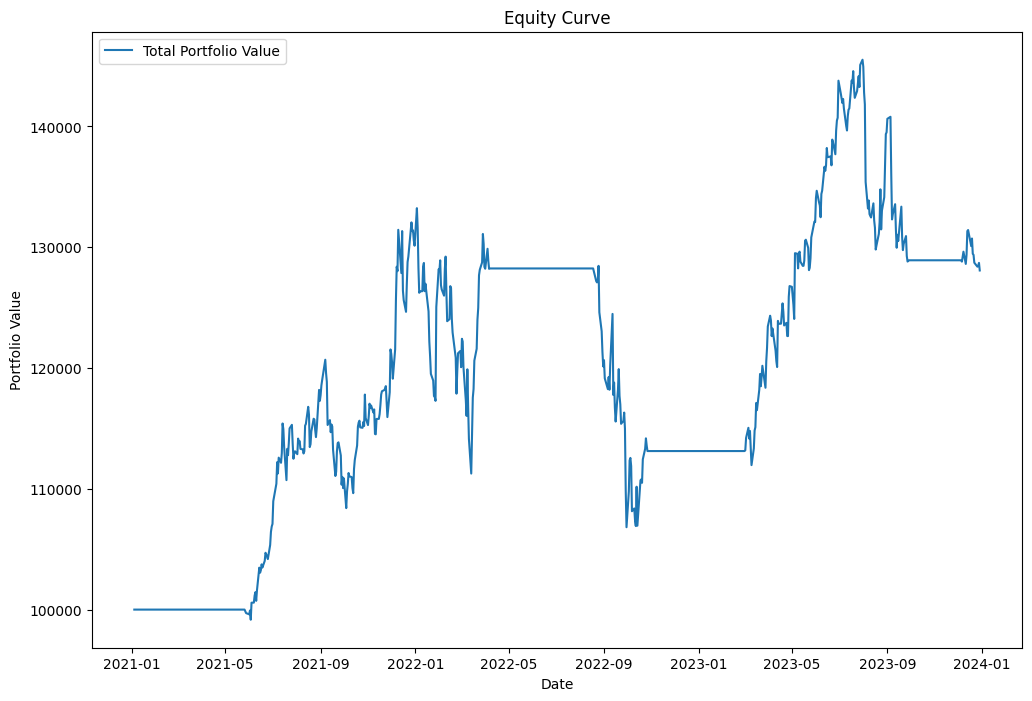

In [ ]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = moving_average_strategy(data, short_window=40, long_window=100)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


[*********************100%%**********************]  1 of 1 completed


Total Return: 39.25%
Annualized Return: 11.72%
Annualized Volatility: 15.58%
Sharpe Ratio: 0.75


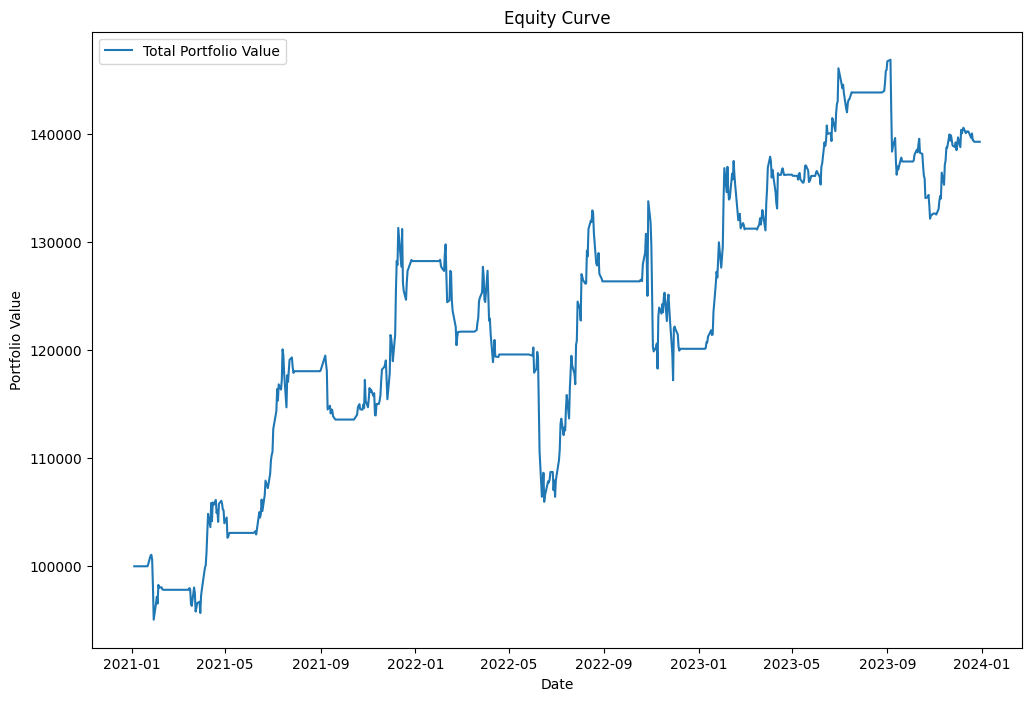

In [ ]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = macd_strategy(data, short_window=12, long_window=26, signal_window=9)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


In [ ]:
!pip install pandas numpy matplotlib yfinance

In [ ]:

#IMPORTING PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [ ]:
# DOWNLOAD DATA FUNCTION
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Date'] = data.index
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return data

In [ ]:
# WILLIAMS %R CALCULATION
def get_wr(high, low, close, lookback):
    highh = high.rolling(lookback).max()
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

In [ ]:
# MACD CALCULATION
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span=fast, adjust=False).mean()
    exp2 = price.ewm(span=slow, adjust=False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns={'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span=smooth, adjust=False).mean()).rename(columns={'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns={0:'hist'})
    return macd, signal, hist

In [ ]:
# Create your own strategy here

# NEW STRATEGY COMBINING WILLIAMS %R AND MACD
def new_strategy(data):
    data['wr_14'] = get_wr(data['High'], data['Low'], data['Close'], 14)
    data['macd'], data['macd_signal'] = get_macd(data['Close'], 26, 12, 9)[:2]

    data['signal'] = 0
    data['positions'] = 0
    for i in range(1, len(data)):
        if data['wr_14'][i-1] > -50 and data['wr_14'][i] < -50 and data['macd'][i] > data['macd_signal'][i]:
            data['signal'][i] = 1  # Buy signal
        elif data['wr_14'][i-1] < -50 and data['wr_14'][i] > -50 and data['macd'][i] < data['macd_signal'][i]:
            data['signal'][i] = 0  # Sell signal
        else:
            data['signal'][i] = data['signal'][i-1]
        data['positions'][i] = data['signal'][i]

    return data


In [ ]:
# BACKTEST FUNCTION
def backtest(data, initial_capital):
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions['Stock'] = 0.0  # Initialize the 'Stock' column with 0.0
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)

    # Initial cash
    portfolio['cash'] = initial_capital
    portfolio['holdings'] = 0.0
    portfolio['total'] = initial_capital
    portfolio['returns'] = 0.0

    # Iterating through the data to simulate the trades
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1 and portfolio['cash'].iloc[i-1] >= data['Close'].iloc[i] * 100:
            # Buy signal and enough cash available
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1] + 100
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1] - data['Close'].iloc[i] * 100
        elif data['signal'].iloc[i] == 0 and positions['Stock'].iloc[i-1] >= 100:
            # Sell signal and enough stock available
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1] - 100
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1] + data['Close'].iloc[i] * 100
        else:
            # No trade, carry forward previous positions and cash
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1]
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1]

        # Calculate holdings
        portfolio['holdings'].iloc[i] = positions['Stock'].iloc[i] * data['Close'].iloc[i]
        portfolio['total'].iloc[i] = portfolio['cash'].iloc[i] + portfolio['holdings'].iloc[i]
        portfolio['returns'].iloc[i] = portfolio['total'].pct_change().iloc[i]

    return portfolio


In [ ]:
# GENERATE REPORT FUNCTION
def generate_report(portfolio, initial_capital):
    total_return = portfolio['total'][-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (252 / len(portfolio)) - 1
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    plt.figure(figsize=(12, 8))
    plt.plot(portfolio['total'], label='Total Portfolio Value')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


Total Return: 33.41%
Annualized Return: 10.13%
Annualized Volatility: 9.77%
Sharpe Ratio: 1.04


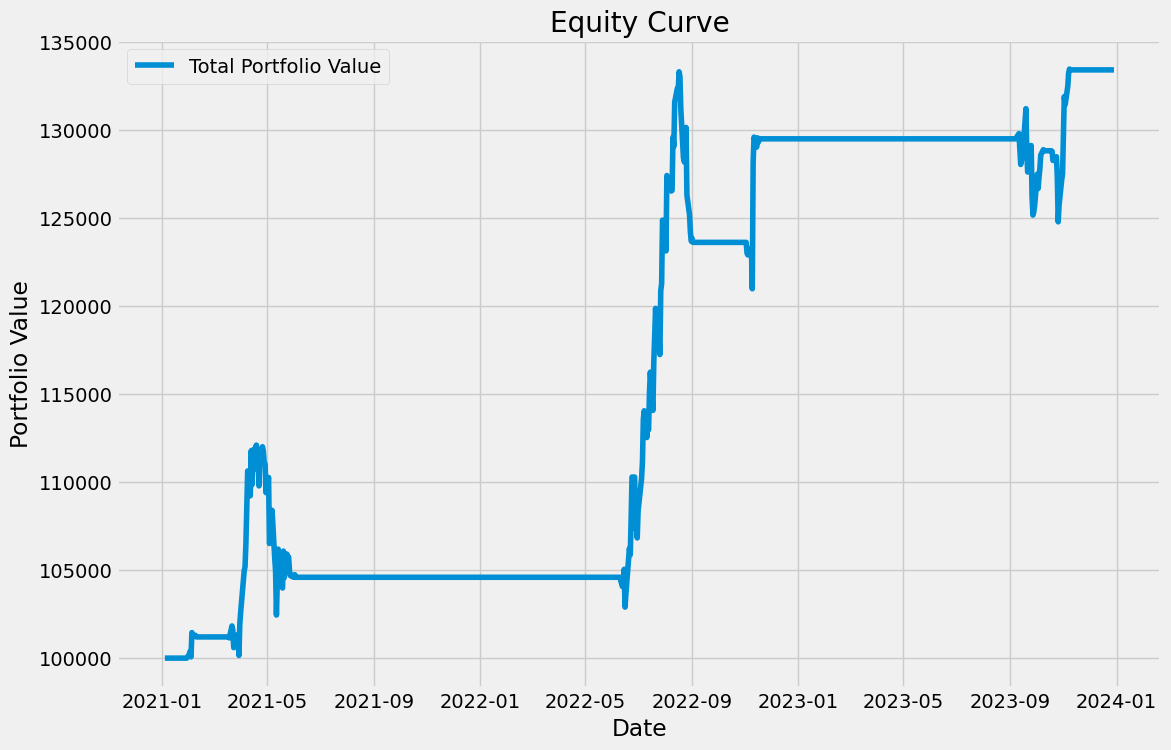

In [ ]:

# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = new_strategy(data)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)
